In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares,differential_evolution
from numpy.linalg import inv
import emcee
import corner
from scipy.interpolate import interp1d
from scipy.stats import linregress
from scipy import stats

from DynamicModel_Package.DynamicModel2D_Base import DynamicModel2D

In [ ]:
df_all = pd.read_csv('ll_tests_by_patient_and_dpi_one_row.csv',index_col='Unnamed: 0')
df_virus =  df_all[['patient.numbear','dpi','qPCR Log10 copies/ml']]

df_all = df_all[df_all['dpi']>0]
columns_pro  = ['IFN-a2a','IL-1a','IL-1b','TNF-a','IL-6','CCL4','CCL2']
df_pro = df_all[['patient.number','dpi','IFN-a2a','IL-1a','IL-1b','TNF-a','IL-6','CCL4','CCL2']]
df_il10 = df_all[['patient.number','dpi','IL-10']]


In [ ]:
def fwhm (t,y):
    y = np.array(y)-np.min(y)
    max_y = np.max(y)
    half_max = max_y / 2
    indices = np.where(y >= half_max)[0]
    left_idx = indices[0]
    right_idx = indices[-1]
    if left_idx == 0:
        t_left = t[0]
    else:
        f_interp = interp1d(y[left_idx-1:left_idx+1], t[left_idx-1:left_idx+1])
        t_left = f_interp(half_max)
    if right_idx == len(y)-1:
        t_right = t[-1]
    else:
        f_interp = interp1d(y[right_idx:right_idx+2], t[right_idx:right_idx+2])
        t_right = f_interp(half_max)

    fwhm = t_right - t_left
    return fwhm,t_left,t_right


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_72934/2521854107.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pro[column+'.rank'] = (df_pro[column]-df_pro[column].min())/((df_pro[column]-df_pro[column].min()).max())
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_72934/2521854107.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pro['sum'] = df_pro[columns_pro].sum(axis=1)
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_72934/2521854107.py:11: SettingWithCopy

[1.23949324 1.15162721 1.14427457 0.85115915 1.54139577 0.897349
 1.16718803 1.0475602  0.87361873 0.2601715  0.51739356 0.91252697
 0.53039936 0.37971594]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 0  1  2  4  6  7 11]
0 11
0 12
[0.97932173 0.8914557  0.88410307 0.59098764 1.28122426 0.63717749
 0.90701653 0.7873887  0.61344723 0.         0.25722205 0.65235547]
[0.    0.    0.    0.    0.    0.    1.5   7.326 8.307 8.41  7.796 8.221
 6.996 5.431 4.283 3.149]
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 7  8  9 10 11 12 13 14]
7 14
6 15
[1.5   7.326 8.307 8.41  7.796 8.221 6.996 5.431 4.283]
[1.08381985 1.0100499  0.78977361 1.99957363 1.34685604 1.02221261
 0.98650652 1.37399093 1.2398745  1.00620646 1.01416447 0.64970561
 0.82318309 0.77398762]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[3 4 7]
3 7
2 8
[0.14006801 1.34986802 0.69715043 0.37250701 0.33680091 0.72428532]
[0.    0.    0.    0.    0.    4.663 3.468 5.038 7.967 8.372 

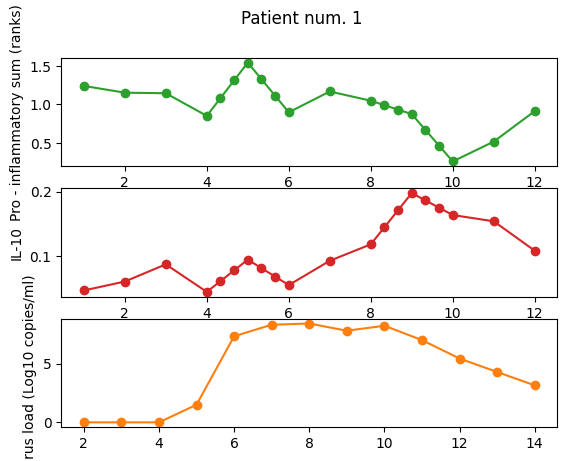

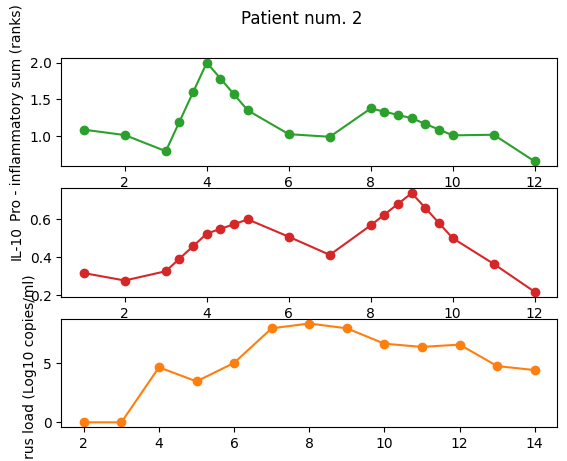

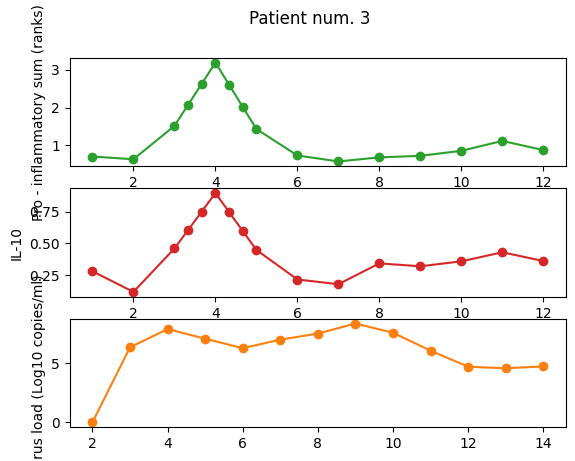

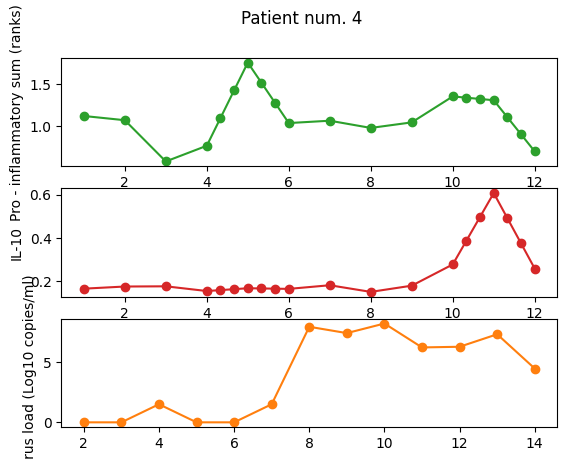

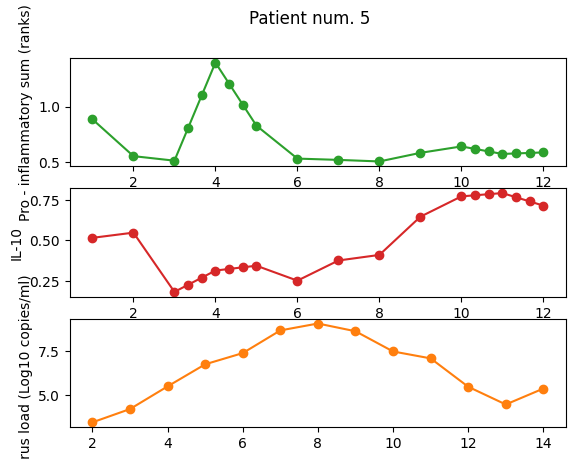

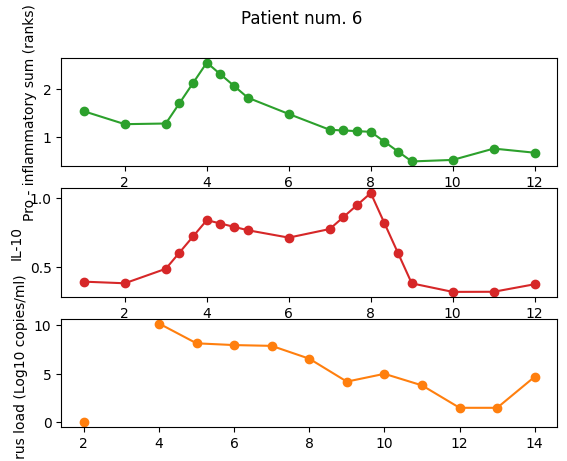

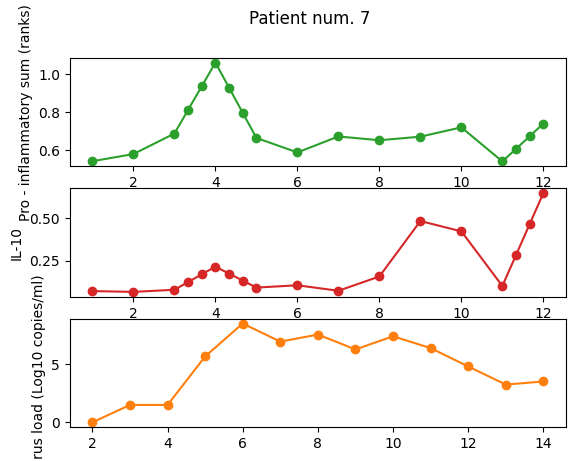

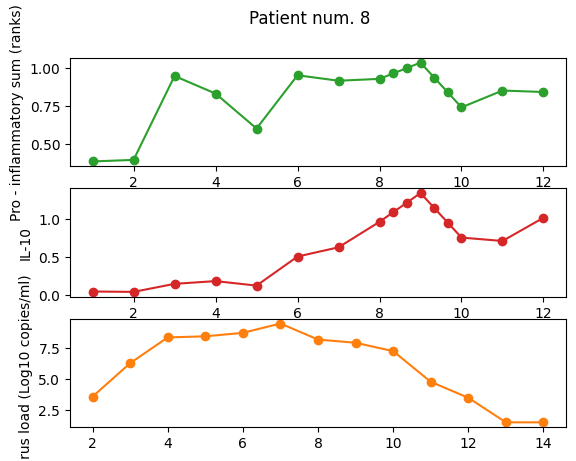

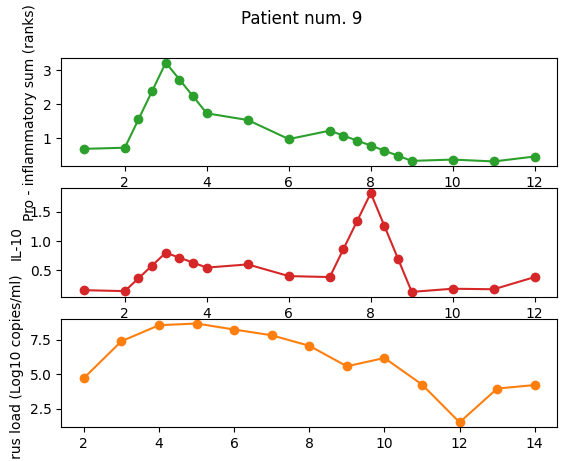

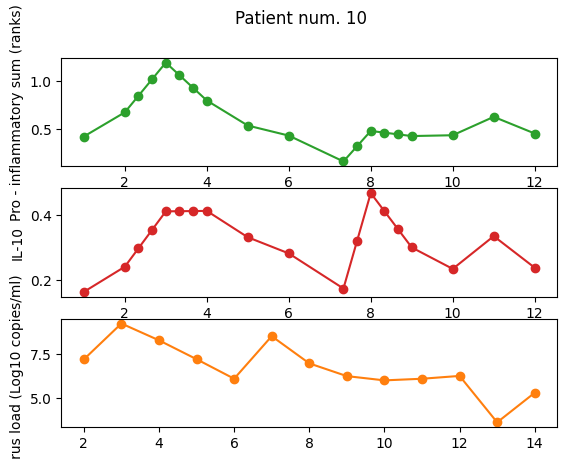

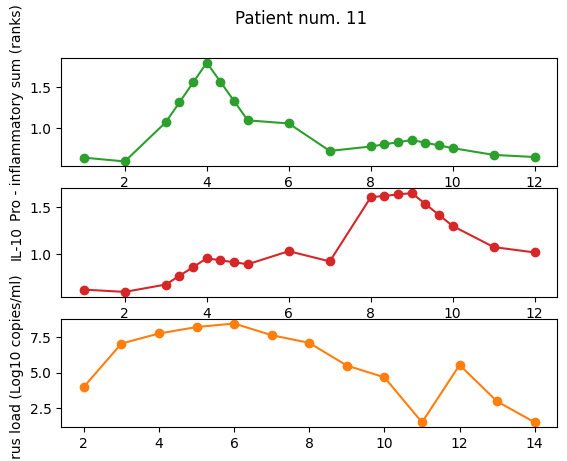

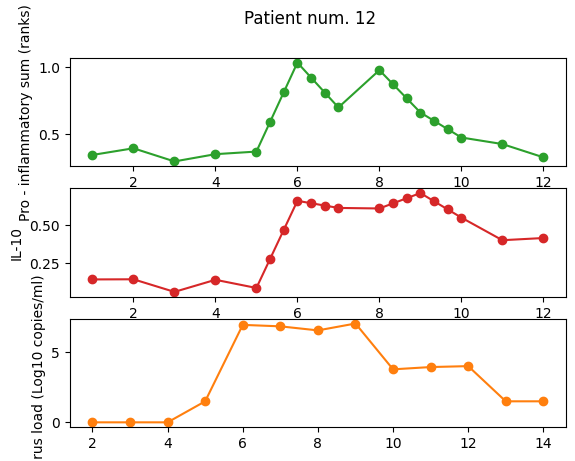

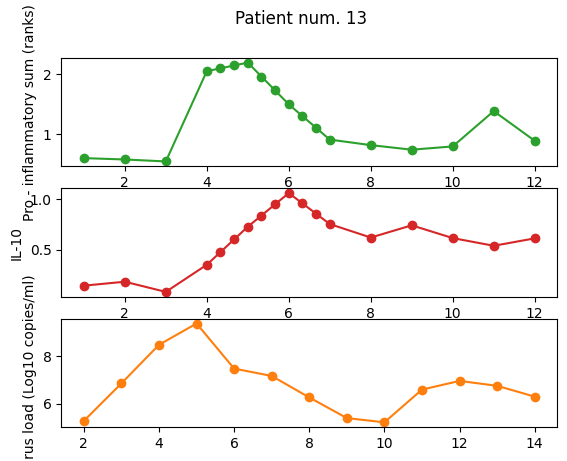

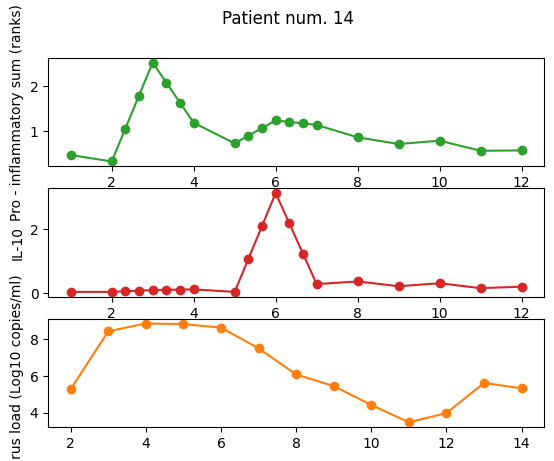

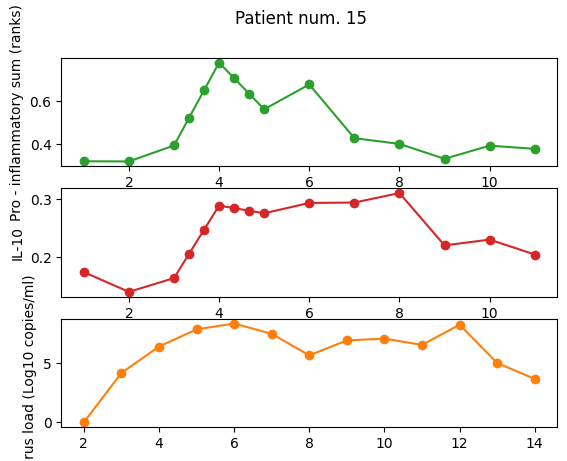

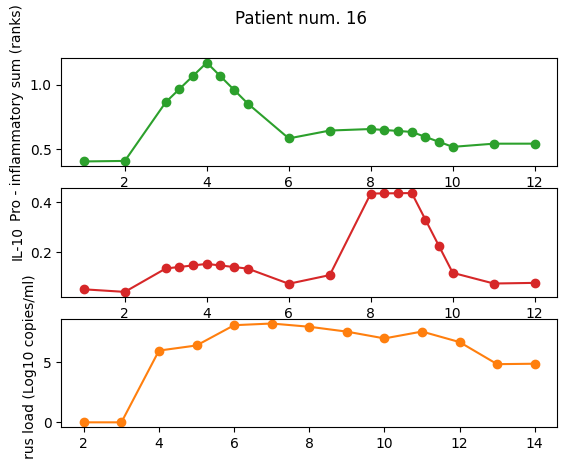

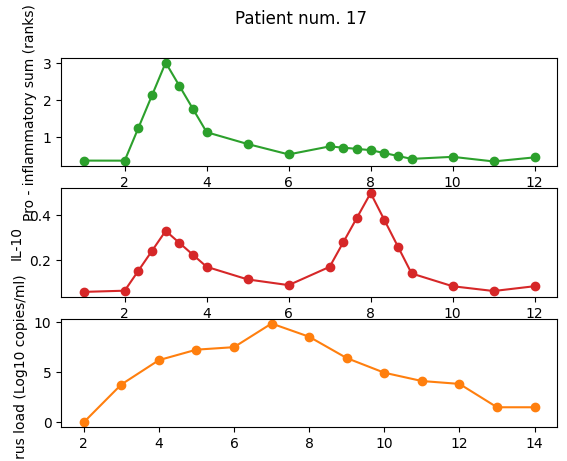

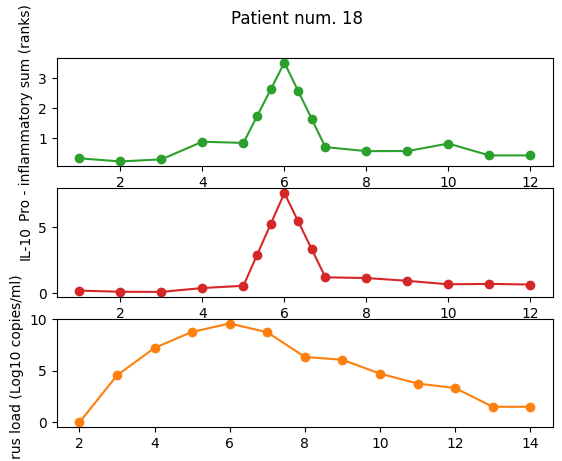

In [ ]:
columns_pro  = ['IFN-a2a','TNF-a','IL-6','CCL4','CCL2']
columns_pro  = ['IFN-a2a','IL-1a','IL-1b','TNF-a','IL-6','CCL4','CCL2']

for column in columns_pro:
    df_pro[column+'.rank'] = (df_pro[column]-df_pro[column].min())/((df_pro[column]-df_pro[column].min()).max())

columns_pro_ranks = [column+'.rank' for column in columns_pro]

patient_nums = np.arange(1,19)
df_pro['sum'] = df_pro[columns_pro].sum(axis=1)
df_pro['sum.ranks'] = df_pro[columns_pro_ranks].sum(axis=1)

def prepare_patient_data (patient_num):
    df_pro_patient = df_pro[df_pro['patient.number']==patient_num].copy()
    df_il0_patient = df_il10[df_il10['patient.number']==patient_num].copy()

    if patient_num == 5:
        df_pro_patient = df_pro_patient[df_pro_patient['dpi']>0]
        df_il0_patient = df_il0_patient[df_il0_patient['dpi']>0]
    if patient_num == 10:
        df_pro_patient = df_pro_patient[df_pro_patient['dpi']!=7]
        df_il0_patient = df_il0_patient[df_il0_patient['dpi']!=7]
    if patient_num==15:
        df_pro_patient = df_pro_patient.iloc[:-1]
        df_il0_patient = df_il0_patient.iloc[:-1]

    return df_pro_patient['sum.ranks'].values,df_il0_patient['IL-10'].values,df_il0_patient['dpi'].values

def interpolate_around_peaks(df, time_col='time', value_cols=['value1', 'value2'], X=1, Y=3):
    df_sorted = df.sort_values(by=time_col).reset_index(drop=True)
    n = len(df_sorted)

    # Get peak indices for each value column
    peak_indices = [df_sorted[col].idxmax() for col in value_cols]

    # Collect window indices ±Y around each peak
    index_set = set()
    for peak_idx in peak_indices:
        start = max(0, peak_idx - Y)
        end = min(n - 1, peak_idx + Y)
        index_set.update(range(start, end))  # Ensure pairs (exclude end to pair with end+1)

    # Sort and remove potential duplicates
    index_list = sorted(index_set)

    # Interpolate X points between each adjacent pair in the window
    interpolated_rows = []
    for i in index_list:
        if i + 1 < n:
            row0 = df_sorted.loc[i]
            row1 = df_sorted.loc[i + 1]
            for j in range(1, X + 1):
                frac = j / (X + 1)
                interp_row = {
                    time_col: row0[time_col] + frac * (row1[time_col] - row0[time_col])
                }
                for col in value_cols:
                    interp_row[col] = row0[col] + frac * (row1[col] - row0[col])
                interpolated_rows.append(interp_row)

    # Combine and return
    interpolated_df = pd.DataFrame(interpolated_rows)
    combined = pd.concat([df_sorted, interpolated_df], ignore_index=True)
    combined = combined.sort_values(by=time_col).reset_index(drop=True)
    
    return combined

def prepare_patient_data_interpolate (patient_num):
    df_pro_patient = df_pro[df_pro['patient.number']==patient_num][['dpi','sum.ranks']].copy()
    df_il0_patient = df_il10[df_il10['patient.number']==patient_num][['dpi','IL-10']].copy()
    df_patient = df_pro_patient.copy()
    df_patient['IL-10'] = df_il0_patient['IL-10']
    df_patient = interpolate_around_peaks(df_patient,'dpi',['sum.ranks','IL-10'],X=2, Y = 1)
    df_patient = df_patient[df_patient['dpi']>0]
    df_patient = df_patient[df_patient['dpi']<=12]
    if patient_num == 10:
        df_patient = df_patient[df_patient['dpi']!=7]
    if patient_num==15:
        df_patient = df_patient.iloc[:-1]
    return df_patient['sum.ranks'].values,df_patient['IL-10'].values,df_patient['dpi'].values


fwhms_pro = []
fwhms_v = []
for patient_num in patient_nums:
    fig,axs = plt.subplots(nrows = 3)
    x_pt, y_pt, t_pt = prepare_patient_data_interpolate(patient_num)
    axs[0].plot(t_pt,x_pt,color = 'tab:green',marker = 'o')
    axs[0].set_ylabel('Pro - inflammatory sum (ranks)')
    axs[1].plot(t_pt,y_pt,color = 'tab:red',marker = 'o')
    axs[1].set_ylabel('IL-10')
    fig.suptitle(f'Patient num. {patient_num}')
    df_pro_patient = df_pro[df_pro['patient.number']==patient_num]
    df_il0_patient = df_il10[df_il10['patient.number']==patient_num]
    df_virus_patient = df_virus[df_virus['patient.number']==patient_num]
    fwhms_pro.append(fwhm(df_pro_patient['dpi'].dropna().values,df_pro_patient['sum.ranks'].dropna().values)[0])
    fwhms_v.append(fwhm(df_virus_patient['dpi'].dropna().values,df_virus_patient['qPCR Log10 copies/ml'].dropna().values)[0])
 
    df_virus_patient = df_virus_patient[df_virus_patient['dpi']>=2]
    axs[2].plot(df_virus_patient['dpi'],df_virus_patient['qPCR Log10 copies/ml'],marker = 'o',color = 'tab:orange')
    axs[2].set_ylabel('Virus load (Log10 copies/ml)')



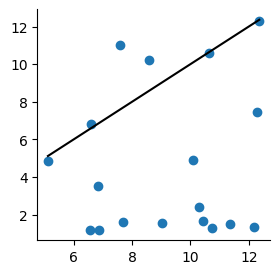

In [ ]:
fig,ax = plt.subplots(figsize = (3,3))
ax.spines[['top', 'right']].set_visible(False)
ax.scatter(fwhms_v,fwhms_pro)


slope, intercept, r_value, p_value, std_err = linregress(fwhms_v,fwhms_pro)
y_fit = slope * np.array(fwhms_v) + intercept
#ax.plot(fwhms_v, y_fit, color='black', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
#ax.text(1, 0.5, f'$r = {r_value:.2f}$ \n$ p = {p_value:.2f}$', transform=ax.transAxes,
#        verticalalignment='top', fontsize=12)

ax.plot(np.linspace(min(fwhms_v),max(fwhms_v),25),np.linspace(min(fwhms_v),max(fwhms_v),25),color = 'black')
fig.savefig('figures/model_fit_to_patients/pro_inflamm_il10/fwhm_pro_vs_virus.png',dpi = 600, bbox_inches = 'tight')
fig.savefig('figures/model_fit_to_patients/pro_inflamm_il10/fwhm_pro_vs_virus.pdf',dpi = 600, bbox_inches = 'tight')


In [15]:
print(df_il10.head())

   patient.number  dpi     IL-10
2               1  1.0  0.047369
3               1  2.0  0.061192
4               1  3.0  0.087701
5               1  4.0  0.045167
6               1  5.0  0.094953


Estimated parameters: [3.05889474e+00 2.25975974e+00 8.75395663e-05 1.72578538e+00
 9.95725641e-02 5.27641765e-01 4.15305562e+00 9.95725641e-02]
R²: 0.6100487224339968


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


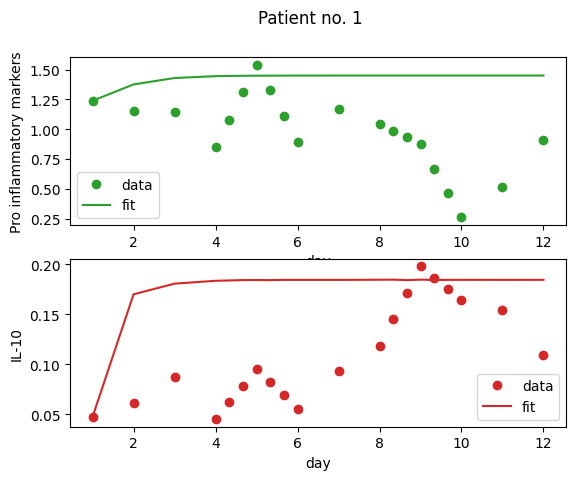

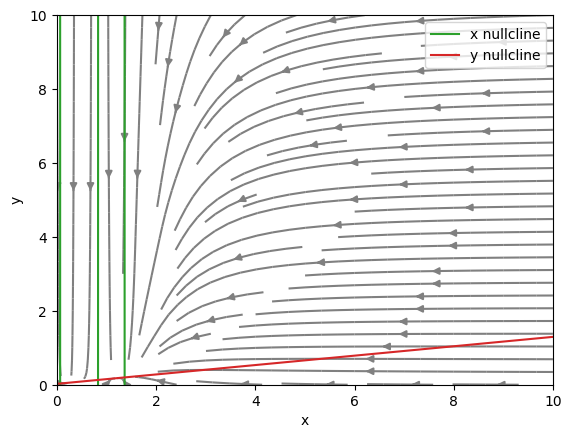

Estimated parameters: [3.07151276 3.60795903 1.30017436 1.77139032 0.0140327  0.34848991
 0.72938348 0.0140327 ]
R²: 0.7619703529900079


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


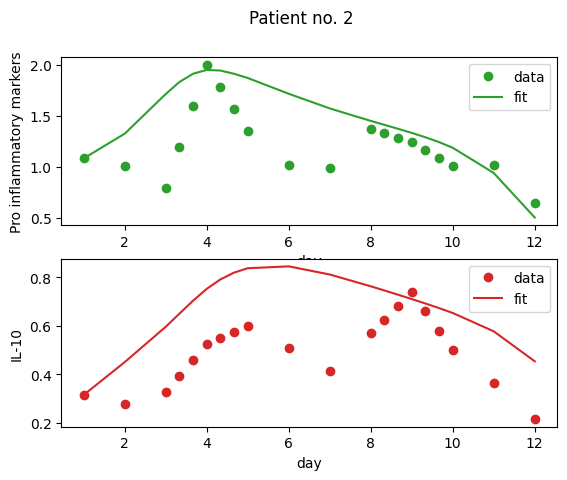

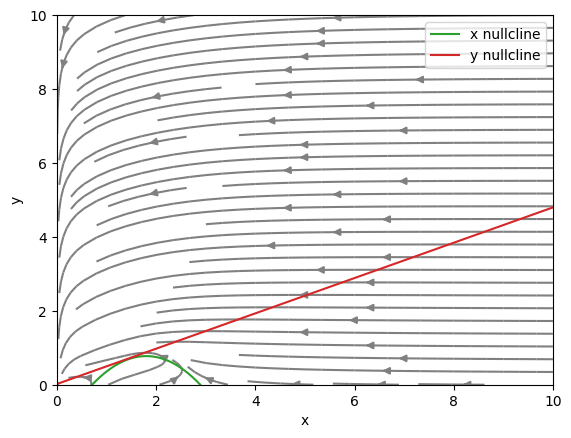

Estimated parameters: [4.20083718 3.37122157 0.63399428 1.13778098 0.12180793 0.93075829
 3.23698405 0.12180793]
R²: -0.16139515415536154


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


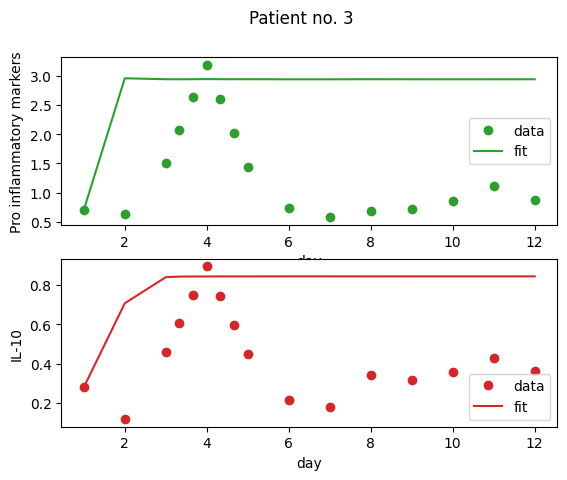

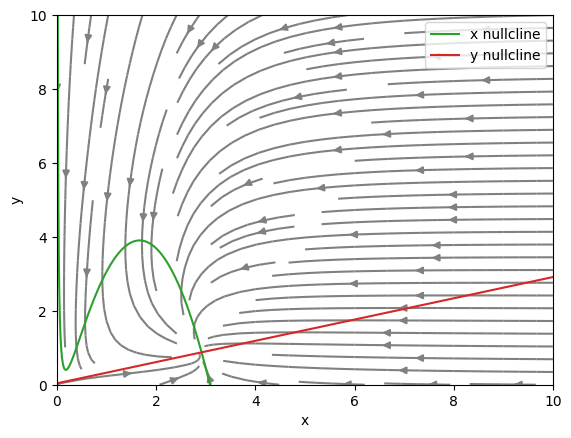

Estimated parameters: [1.24912335 3.03205747 0.01022436 1.66395509 0.61667463 0.49954952
 1.51094448 0.61667463]
R²: 0.7333424360591357


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


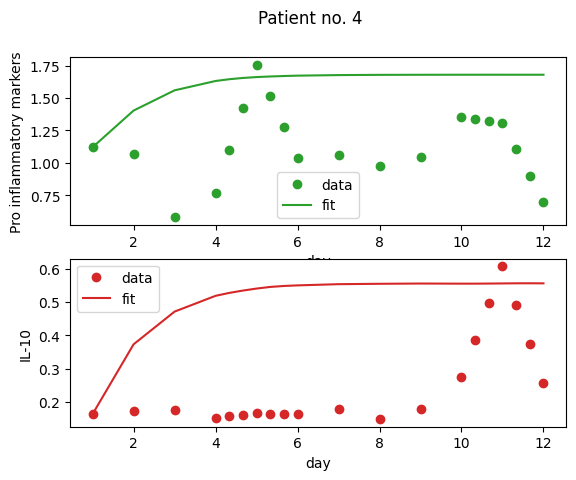

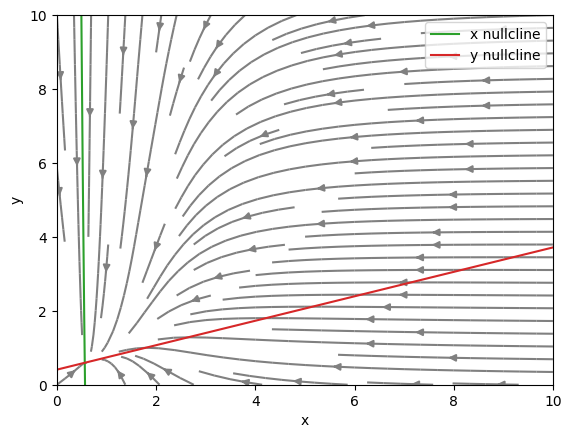

Estimated parameters: [3.05491491e+00 7.99630772e+00 4.93440911e+00 2.03234210e+00
 4.62067319e-01 3.03410528e-02 1.33270596e-07 1.74488473e+00]
R²: 0.30658839015772343


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


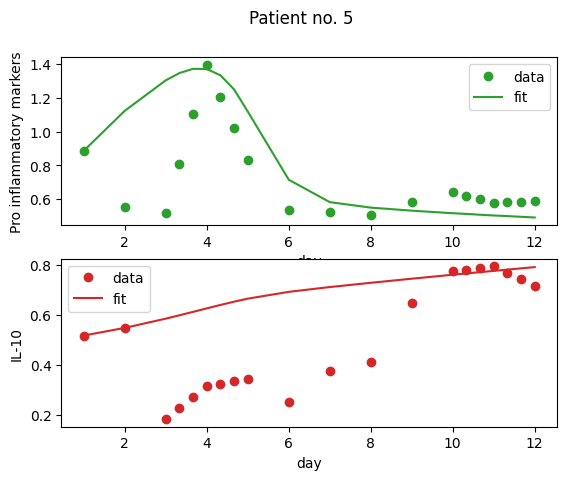

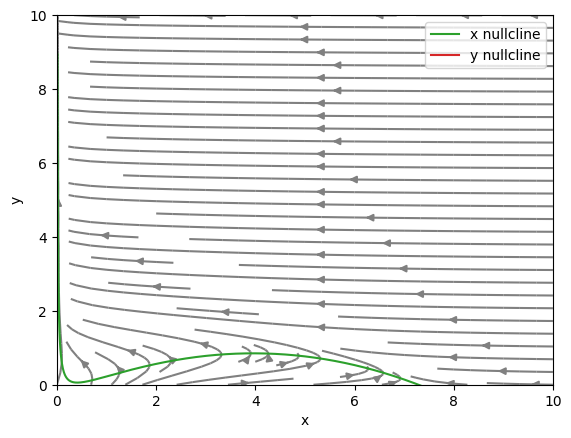

Estimated parameters: [2.67645622 5.34965504 0.88461952 3.42121149 0.85473133 0.14471382
 0.23451707 0.72024914]
R²: 0.7875138389926232


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


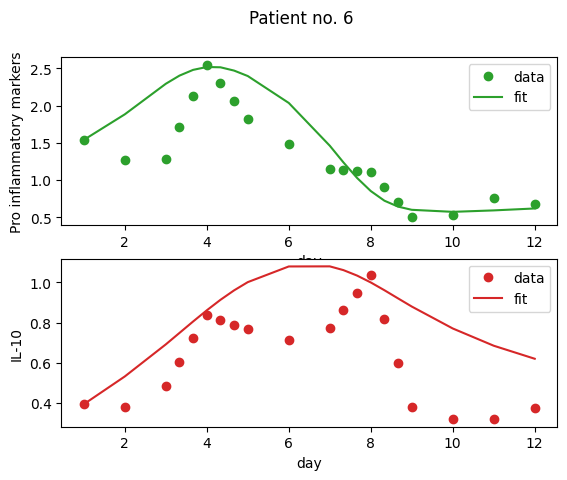

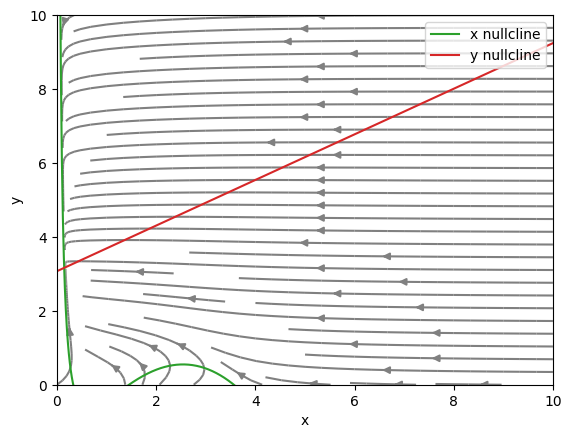

Estimated parameters: [2.66222729e+00 5.83138343e+00 1.54038648e+00 3.75343185e+00
 9.56953344e-01 6.40380712e-02 9.56598390e-35 9.56953344e-01]
R²: 0.7568867107821606


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


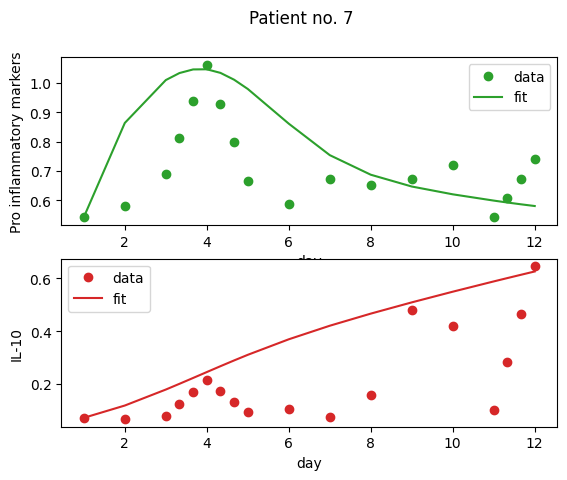

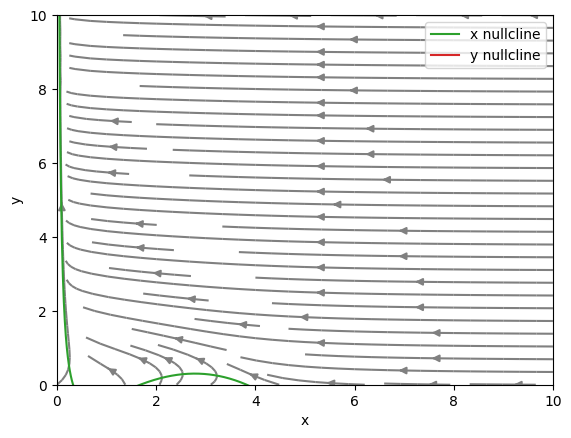

Estimated parameters: [1.55220963e+00 4.34654062e-01 8.13991164e-11 8.15561213e-01
 1.46544883e+00 2.10527246e-01 7.39322449e-02 1.46541302e+00]
R²: 0.5762960125627761


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


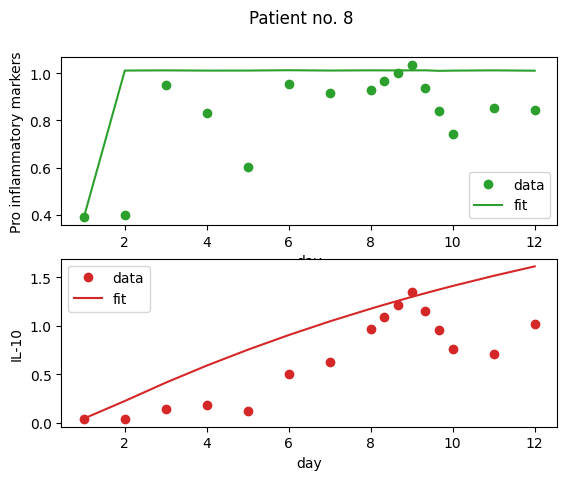

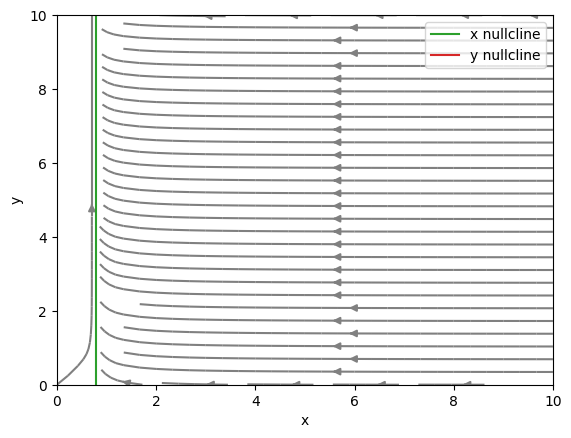

Estimated parameters: [3.40266911e+00 4.13474586e+00 1.24204607e+00 1.46945439e+00
 6.57429237e-04 2.58117176e-01 2.48769003e-01 6.54620968e-04]
R²: 0.4931144608488829


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


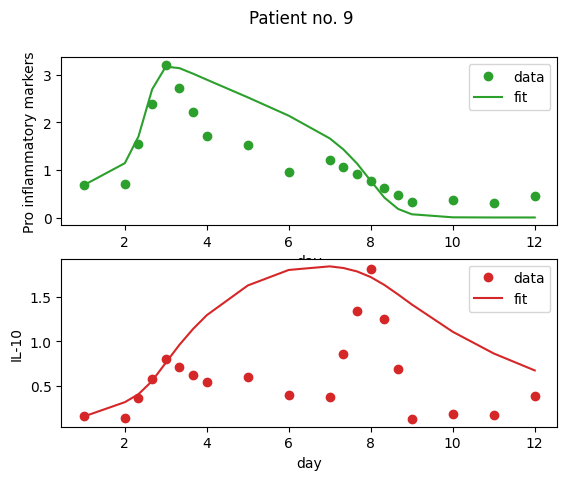

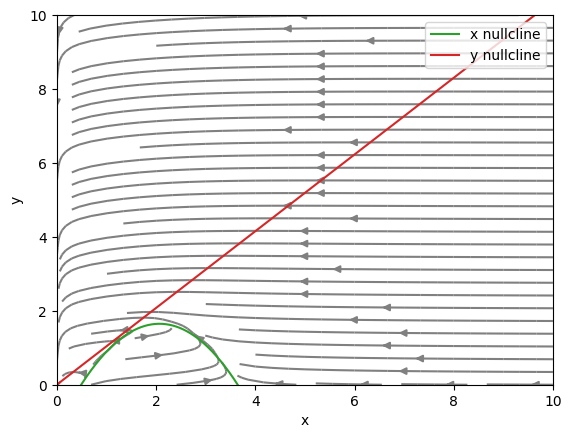

Estimated parameters: [2.80062917 5.87476968 4.82891216 1.83570102 0.60726844 0.17201072
 0.18003712 0.60726844]
R²: 0.8306422519430263


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


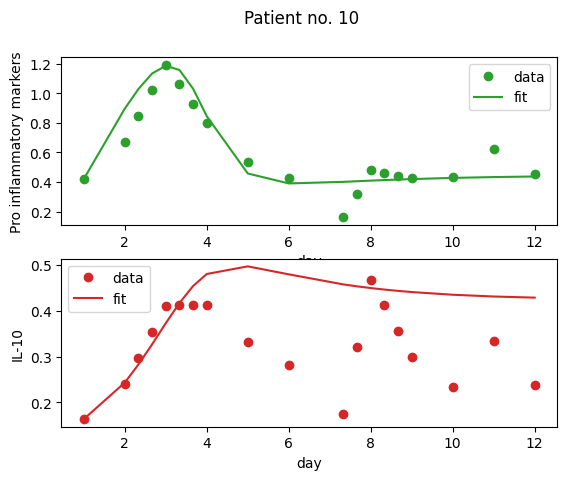

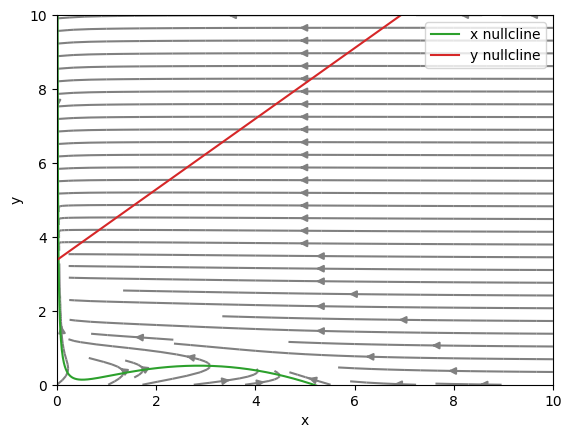

Estimated parameters: [1.74262645 3.51344667 0.82837181 1.13657964 0.52384328 0.15724428
 0.06571814 0.40433098]
R²: 0.5804807957311693


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


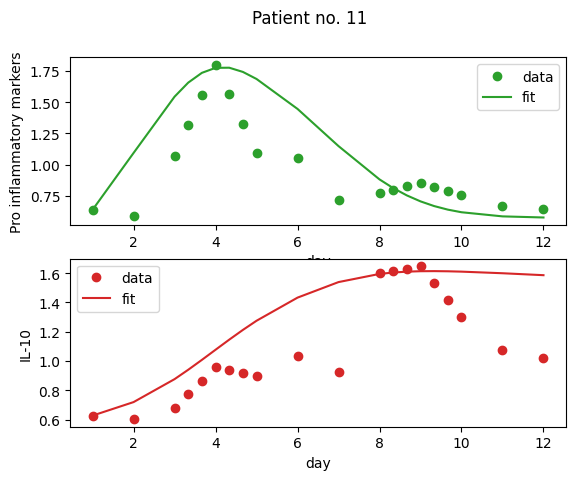

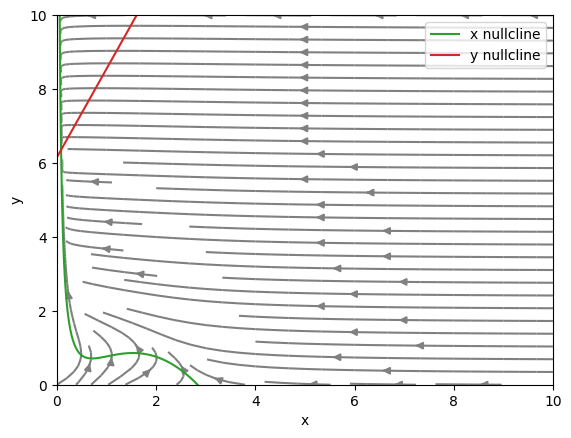

Estimated parameters: [3.77274509 2.5590455  1.89433555 1.4757426  0.15164338 0.27935595
 0.33281537 0.15164338]
R²: 0.6445811230607947


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


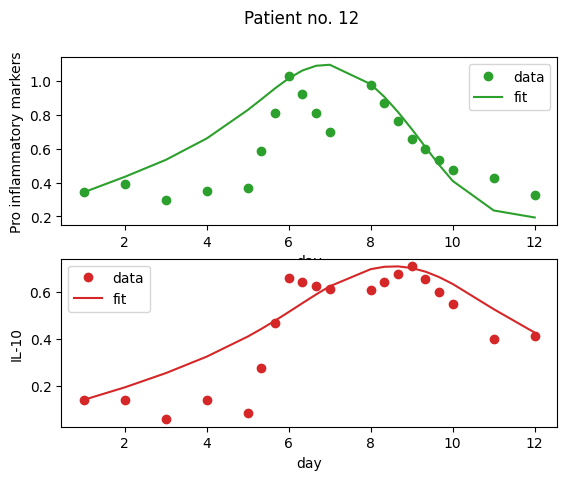

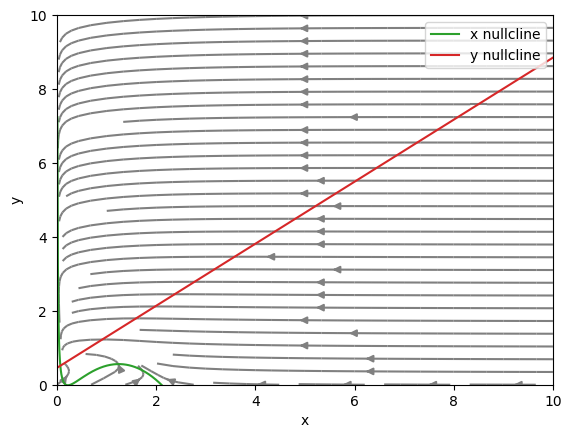

Estimated parameters: [2.36791688 3.0554136  0.06321842 1.80670301 0.340853   0.72381549
 1.47191309 0.340853  ]
R²: 0.4176181051799758


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


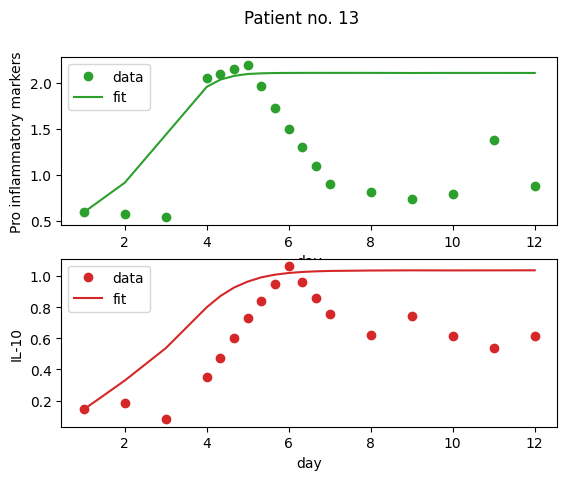

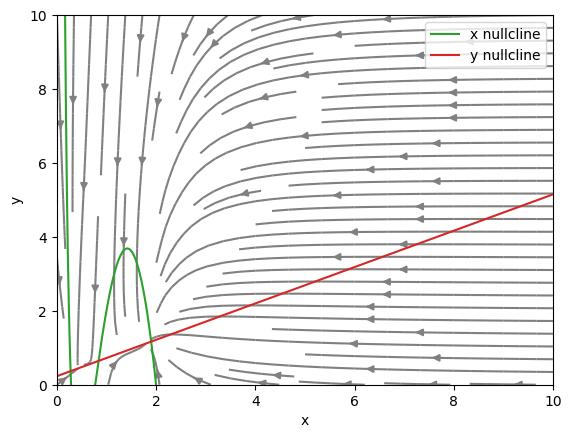

Estimated parameters: [4.50168307 4.10143576 0.77052686 3.10742158 0.09324511 0.66704348
 0.3528418  0.80081566]
R²: -0.2857018158334592


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


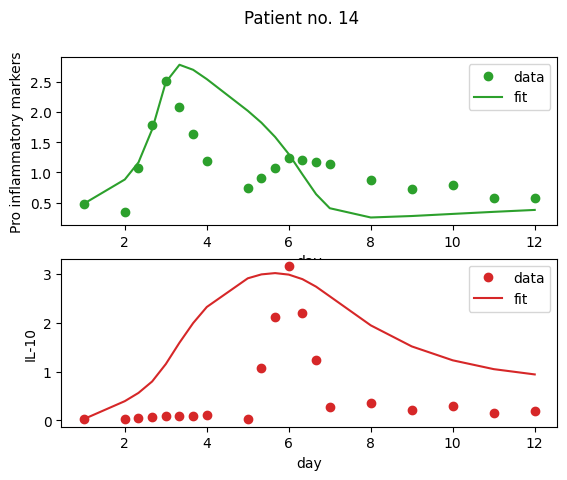

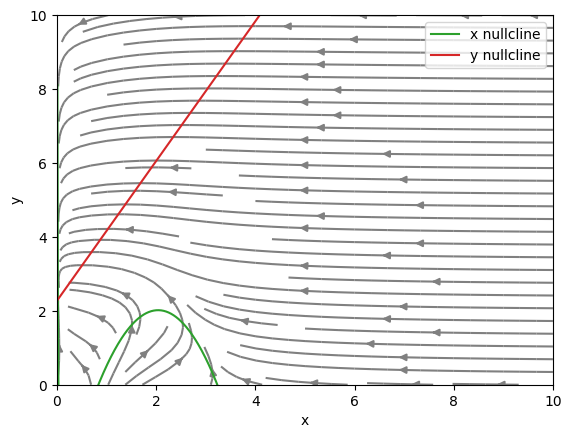

Estimated parameters: [4.85901402 0.79899523 0.08927718 3.01679991 1.03826858 0.77057737
 1.89279455 1.03826858]
R²: 0.327727140370335


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


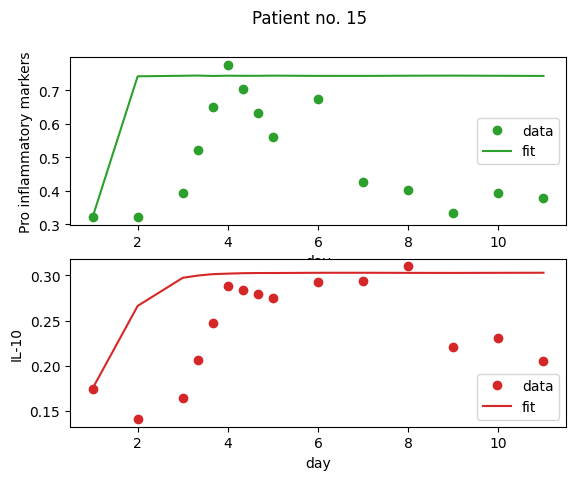

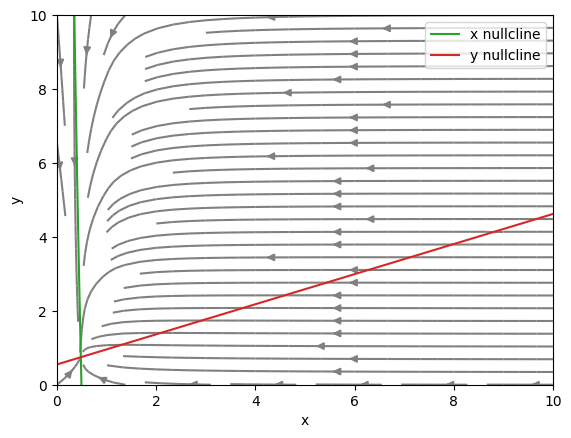

Estimated parameters: [2.24646864e+00 2.20375761e+00 2.13027042e+00 1.26219543e+00
 6.07311158e-01 9.16092067e-02 1.21770373e-01 3.33221002e-04]
R²: 0.8356532860517106


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


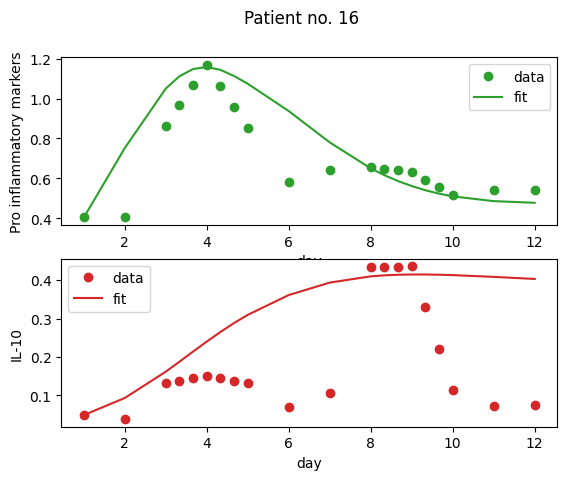

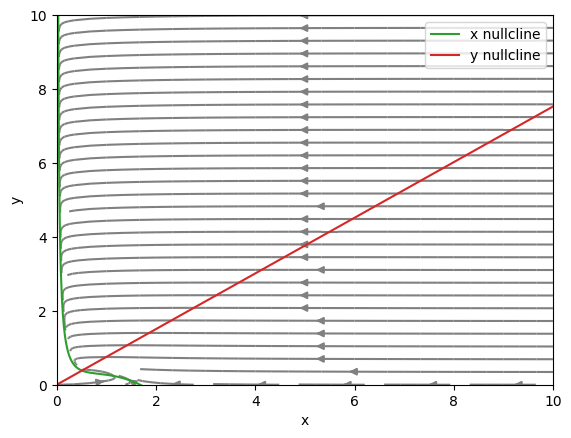

Estimated parameters: [2.4349169  7.18566288 7.6733146  1.71598257 0.91102076 0.11494378
 0.13139765 0.55345825]
R²: 0.7794497510852564


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


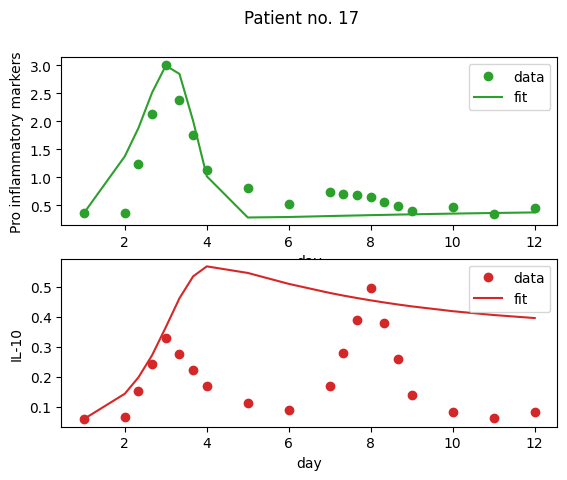

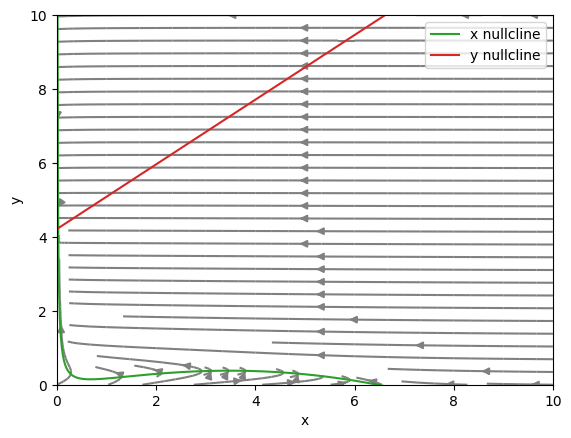

Estimated parameters: [1.85811119 5.04988245 0.12782128 1.57150584 0.41062964 2.58585184
 1.16852982 0.41056037]
R²: -0.4146178732004371


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


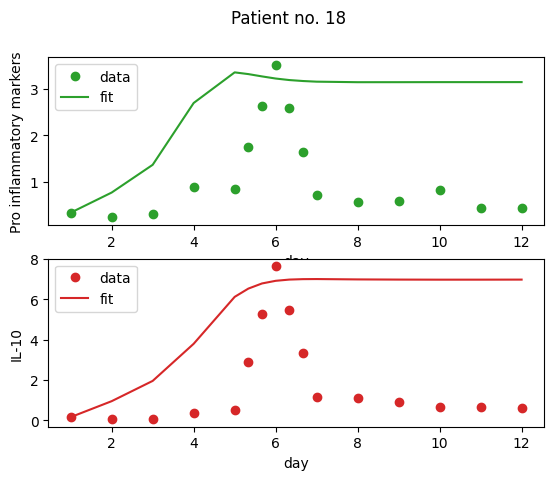

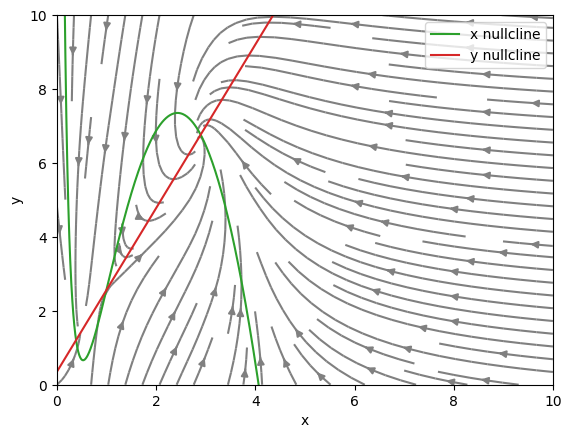

In [5]:
def ode_system(t, y, params):
    # Example with 3 variables and 9 parameters
    p1,p2,p3,p4,p5,p6,p7,u = params
    x,y_ = y

    dxdt = p1 * x**2 * (1-x/p2) - p3 * x * y_ - p4 * x + p5 + u
    dydt = p6 * x - p7 * y_
    return [dxdt,dydt]

def dxdt (variables, parameters):
    x = variables['x']
    y = variables['y']
    t = variables['t']
    p1 = parameters['p1']
    p2 = parameters['p2']
    p3 = parameters['p3']
    p4 = parameters['p4']
    p5 = parameters['p5']
    return p1 * x**2 * (1-x/p2) - p3 * x * y - p4 * x + p5 

def dydt (variables, parameters):
    x = variables['x']
    y = variables['y']
    p6 = parameters['p6']
    p7 = parameters['p7']
    p8 = parameters['p8']
    return p6 * x - p7 * y + p8

def nc_x (x,parameters):
    p1 = parameters['p1']
    p2 = parameters['p2']
    p3 = parameters['p3']
    p4 = parameters['p4']
    p5 = parameters['p5']
    return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)

def nc_y (x,parameters):
    p6 = parameters['p6']
    p7 = parameters['p7']
    p8 = parameters['p8']

    return (p6 * x + p8) / p7 

def simulate(params, t_data, y0):
    sol = solve_ivp(lambda t, y: ode_system(t, y, params), 
                    [t_data[0], t_data[-1]], y0, t_eval=t_data, 
                    method='RK45', vectorized=False)
    sol.y[sol.y<0] = 0
    return sol.y.T  # shape: (n_timepoints, 3)

# --- Define cost function to minimize ---
def cost_function(params, t_data, y0, y_data):
    y_sim = simulate(params, t_data, y0)
    return (y_sim - y_data).ravel()

def cost_function_weighted(params, t_data, y0, y_data, weights=None):
    y_sim = simulate(params, t_data, y0)
    
    if np.any(np.isinf(y_sim)) or y_sim.shape != y_data.shape:
        return np.full(np.prod(y_data.shape), 1e6)  # large penalty

    # Identify valid (non-NaN) entries
    idx_time, idx_var = np.where(~np.isnan(y_data))
    residuals = y_sim[idx_time, idx_var] - y_data[idx_time, idx_var]

    if weights is not None:
        point_weights = weights[idx_time, idx_var]
        residuals = residuals * point_weights

    return residuals
inital_guesses_from_lsq = []
for patient_num in np.arange(1,19):
    ifna,il10,days = prepare_patient_data_interpolate(patient_num=patient_num)
    y0 = [ifna[0],il10[0]]
    y_data = np.array([ifna,il10]).T
    weights = np.ones_like(y_data)
    weights[np.argmax(ifna),0] = 10
    weights[np.argmax(il10),1] = 10

    initial_guess = [1,max(ifna),1,1,1,1,1,1]
    result = least_squares(cost_function_weighted, initial_guess,bounds = (0,np.inf), args=(days, y0, y_data,weights))
    residuals = result.fun
    dof = len(residuals) - len(result.x)

    # Estimate of residual variance
    residual_variance = np.sum(residuals**2) / dof

    # Approximate covariance matrix of parameters
    J = result.jac
    #cov = residual_variance * inv(J.T @ J)

    # Standard deviation (sqrt of diagonal)
    #param_std = np.sqrt(np.diag(cov))

    print("Estimated parameters:", result.x)
    #print("Standard deviations:", param_std)

    y_fit = simulate(result.x, days, y0)

    fig,axs = plt.subplots(nrows = 2)
    dfs = [ifna,il10]
    labels = ['Pro inflammatory markers','IL-10']
    colors = ['tab:green','tab:red']
    residuals = y_fit - y_data
    R2 = 1 - np.var(residuals) / np.var(y_data)
    print("R²:", R2)

    for i,ax in enumerate(axs):
        ax.plot(days,dfs[i],'o',c = colors[i],label = 'data')
        ax.plot(days, y_fit[:, i], '-',c = colors[i],label = 'fit')
        ax.set_xlabel('day')
        ax.set_ylabel(labels[i])
        ax.legend()
    fig.suptitle(f'Patient no. {patient_num}')
    parameters = {'p1':result.x[0],'p2':result.x[1],'p3':result.x[2],'p4':result.x[3],'p5':result.x[4],'p6':result.x[5],'p7':result.x[6],'p8':result.x[7]}
    model = DynamicModel2D('x',dxdt,parameters,'y',dydt,parameters)
    model.add_nullcline('x',nc_x,parameters,True)
    model.add_nullcline('y',nc_y,parameters,True)
    model.plot_phase_portrait(0,20,20,[0,10],[0,10],['tab:green','tab:red'])
    plt.show()
    inital_guesses_from_lsq.append(result.x)

In [17]:
import pandas as pd
import re

# Load the Excel file
file_path = "mcmc_results/pro_inflamm_vs_il10.xlsx"  # Update this path if needed
xls = pd.ExcelFile(file_path)

# Load the sheet (assuming it's the first one)
df = xls.parse(xls.sheet_names[0])

# Drop the first two rows (header info) and reset the column names
df_cleaned = df.drop(index=[0, 1]).reset_index(drop=True)

# Select only the columns with parameter values (p1 to p8)
param_columns = df_cleaned.columns[1:9]

# Function to extract the median (value before brackets)
def extract_median(cell):
    if isinstance(cell, str):
        match = re.match(r"([0-9.]+)\s*\(", cell)
        if match:
            return float(match.group(1))
    return None

# Build the list of lists
parameters_per_patient = [
    [extract_median(cell) for cell in row]
    for _, row in df_cleaned[param_columns].iterrows()
]

# Remove rows that are entirely None (in case of trailing empty rows)
parameters_per_patient = [row for row in parameters_per_patient if any(x is not None for x in row)]

# Now `parameters_per_patient` contains the desired data
print(parameters_per_patient)


[[3.22, 3.02, 1.67, 2.73, 0.02, 0.02, 0.1, 0.74], [0.44, 7.67, 1.45, 0.05, 0.4, 0.09, 0.18, 0.23], [4.58, 4.48, 2.44, 3.46, 0.06, 0.29, 0.45, 1.03], [1.13, 4.12, 0.75, 1.31, 0.41, 0.02, 0.01, 0.26], [4.36, 9.2, 5.59, 3.73, 1.97, 0.03, 0.01, 1.05], [1.66, 6.01, 1.03, 1.93, 0.5, 0.16, 0.3, 0.52], [2.37, 2.41, 1.65, 2.09, 0.26, 0.06, 0.02, 1.0], [1.06, 2.23, 0.43, 0.39, 0.07, 0.33, 0.22, 0.04], [3.66, 5.2, 1.38, 4.63, 2.74, 0.17, 0.13, 0.07], [4.06, 7.2, 4.06, 2.87, 0.26, 0.23, 0.31, 1.13], [0.82, 2.64, 1.22, 0.009, 0.65, 0.1, 0.02, 0.34], [0.47, 1.12, 0.91, 0.15, 0.15, 0.18, 0.18, 0.06], [3.36, 5.09, 1.75, 3.47, 1.43, 0.28, 0.49, 0.19], [1.89, 4.77, 0.85, 0.91, 0.05, 0.48, 0.34, 0.41], [9.48, 1.18, 4.09, 4.14, 0.58, 1.54, 3.4, 0.85], [0.455, 2.44, 2.4, 0.2, 0.16, 0.09, 0.15, 0.3], [0.77, 8.24, 2.45, 0.14, 0.46, 0.17, 0.24, 0.56], [6.05, 8.36, 1.46, 3.37, 1.06, 7.49, 3.79, 0.04]]


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/yaelleb/.pyenv/versions/3.11.3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:05<00:00, 175.61it/s]
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[i].plot(days, median[:, i], 'b-', label='Median fit',c = colors[i],lw = 3)
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[i].plot(days, y_data[:, i], 'ko',c = colors[i], label=f'{label} Data')


p1: 3.19 (2.99, 3.64)
p2: 3.34 (3.00, 3.62)
p3: 1.71 (1.42, 2.08)
p4: 2.96 (2.66, 3.77)
p5: 0.21 (-0.14, 0.99)
p6: 0.01 (-0.14, 0.03)
p7: 0.06 (0.00, 0.22)
p8: 0.67 (0.06, 0.85)
Posterior mean estimate: [ 3.23931525  3.31665692  1.72637546  3.06475194  0.33256375 -0.02964139
  0.07709347  0.56249116]
Posterior predictive coverage (95% CI): 72.50%
R²: -1.5206
Weighted R²: 0.7132


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


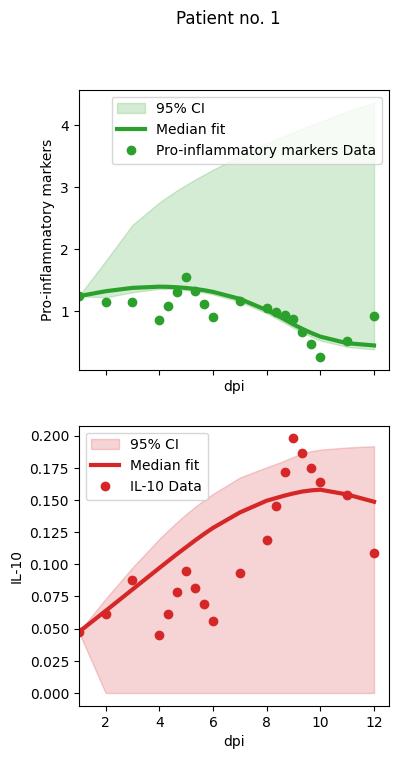

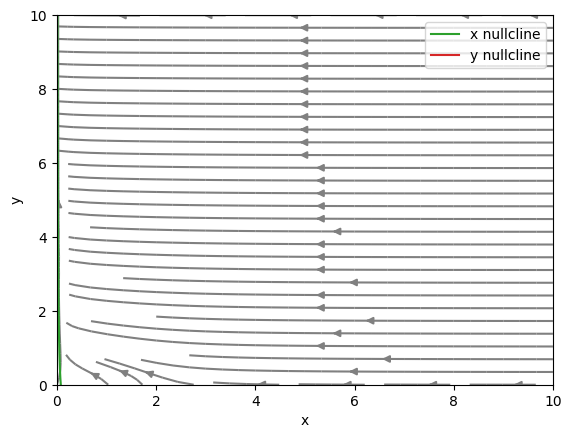

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/yaelleb/.pyenv/versions/3.11.3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:07<00:00, 130.60it/s]
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[i].plot(days, median[:, i], 'b-', label='Median fit',c = colors[i],lw = 3)
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[i].plot(days, y_data[:, i], 'ko',c = colors[i], label=f'{label} Data')


p1: 0.41 (0.29, 0.59)
p2: 6.98 (5.12, 10.71)
p3: 1.26 (1.17, 1.40)
p4: 0.08 (0.01, 0.59)
p5: 0.24 (0.02, 0.57)
p6: 0.10 (0.08, 0.13)
p7: 0.20 (0.14, 0.28)
p8: 0.21 (0.02, 0.57)
Posterior mean estimate: [0.45172097 7.89498235 1.28557203 0.25436211 0.26669849 0.09972395
 0.20315965 0.33027737]
Posterior predictive coverage (95% CI): 47.50%
R²: 0.7156
Weighted R²: 0.6371


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


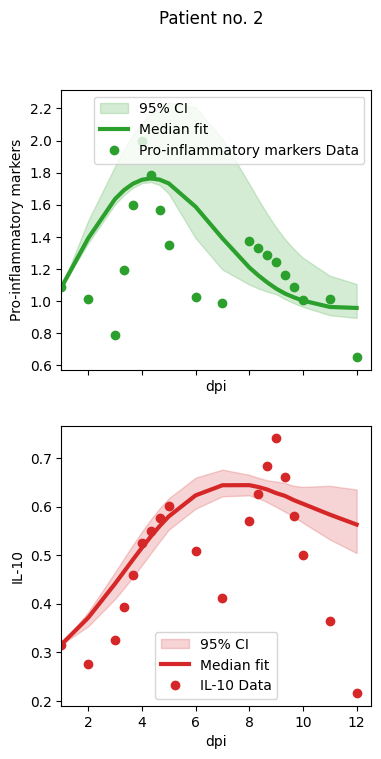

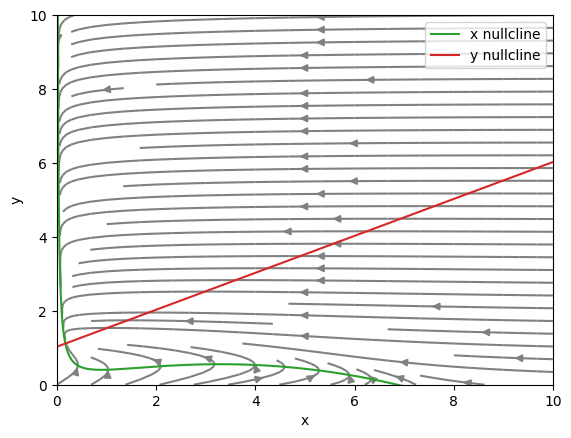

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/yaelleb/.pyenv/versions/3.11.3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:23<00:00, 42.48it/s]
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[i].plot(days, median[:, i], 'b-', label='Median fit',c = colors[i],lw = 3)
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[i].plot(days, y_data[:, i], 'ko',c = colors[i], label=f'{label} Data')


p1: 4.66 (4.05, 5.98)
p2: 5.98 (5.08, 6.27)
p3: 4.83 (3.79, 5.19)
p4: 3.90 (2.35, 5.68)
p5: 0.27 (0.04, 1.53)
p6: 0.33 (0.26, 0.37)
p7: 0.71 (0.47, 0.83)
p8: 1.45 (0.58, 2.20)
Posterior mean estimate: [4.78970801 5.88585546 4.66146255 3.83544307 0.40373794 0.32402163
 0.69651147 1.40084271]
Posterior predictive coverage (95% CI): 50.00%
R²: 0.9357
Weighted R²: 0.9720


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


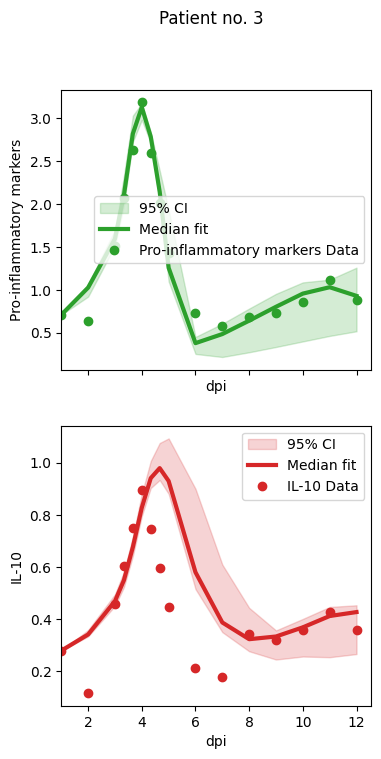

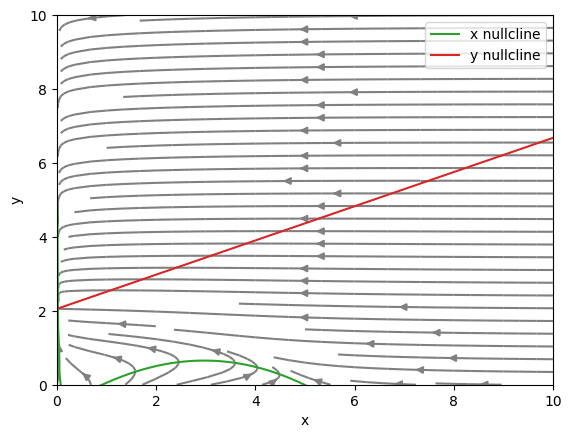

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/yaelleb/.pyenv/versions/3.11.3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:08<00:00, 117.82it/s]
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[i].plot(days, median[:, i], 'b-', label='Median fit',c = colors[i],lw = 3)
/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/2693485854.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[i].plot(days, y_data[:, i], 'ko',c = colors[i], label=f'{label} Data')


p1: 2.37 (1.50, 6.53)
p2: 2.64 (2.00, 7.09)
p3: 1.55 (1.25, 2.03)
p4: 2.17 (1.75, 9.06)
p5: 0.34 (0.02, 1.63)
p6: 0.05 (-0.02, 0.06)
p7: 0.00 (-0.14, 0.02)
p8: 1.01 (0.26, 3.04)
Posterior mean estimate: [ 3.08532757  3.43480207  1.56604253  3.57877527  0.49380077  0.04562129
 -0.00697961  1.23435137]
Posterior predictive coverage (95% CI): 83.33%
R²: 0.7880
Weighted R²: 0.7153


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_31565/1036843908.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1 * x**2 * (1-x/p2) - p4 * x + p5)/(p3 * x)


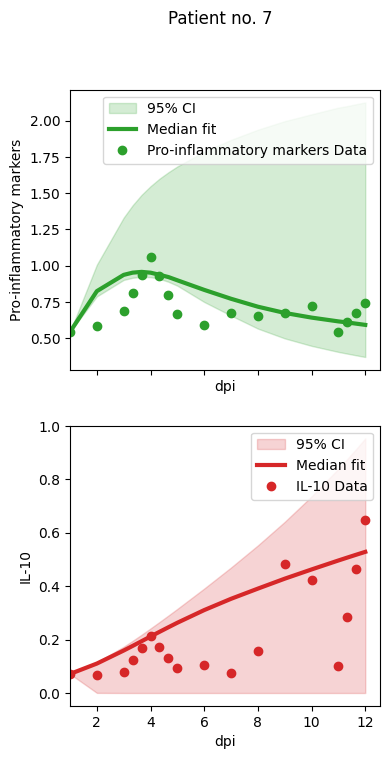

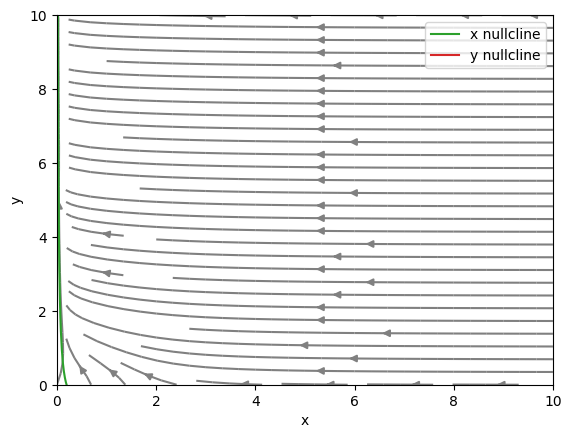

In [ ]:
def params_list_to_dict (params):
    params_dict = {}
    for i,param in enumerate(params):
        params_dict[f'p{i+1}'] = param
    return params_dict


for patient_num,patient_guess in zip(np.arange(1,19),parameters_per_patient):
    ifna,il10,days = prepare_patient_data_interpolate(patient_num=patient_num)
    y0 = [ifna[0],il10[0]]
    if patient_num not in [1,2,3,7]:
        continue
    y_data = np.array([ifna,il10]).T

    def log_likelihood(params):
        y_sim = simulate(params, days, y0)
        if np.any(np.isinf(y_sim)):
            return -np.inf

        idx_time, idx_var = np.where(~np.isnan(y_data))
        y_sim_obs = y_sim[idx_time, idx_var]
        y_data_obs = y_data[idx_time, idx_var]
        
        sigma = 0.05  # assumed noise
        return -0.5 * np.sum(((y_data_obs - y_sim_obs) / sigma) ** 2)
    weights = np.ones_like(y_data)
    weights[np.argmax(ifna),0] = 10
    weights[np.argmax(il10),1] = 10

    def log_likelihood_weighted(params):
        y_sim = simulate(params, days, y0)
        if np.any(np.isinf(y_sim)):
            return -np.inf

        idx_time, idx_var = np.where(~np.isnan(y_data))
        y_sim_obs = y_sim[idx_time, idx_var]
        y_data_obs = y_data[idx_time, idx_var]
        point_weights = weights[idx_time, idx_var]  # matching weights

        sigma = 0.05  # assumed measurement noise
        residuals = (y_data_obs - y_sim_obs) / sigma
        weighted_sq_error = point_weights * residuals**2

        return -0.5 * np.sum(weighted_sq_error)

    # --- Log-prior (uniform over reasonable bounds) ---

    def log_prior(params):
        if np.all((0 <= params) & (params <= 50)):
            return 0.0  # uniform prior log-prob
        return -np.inf  # outside bounds

    # --- Log-posterior ---
    def log_posterior(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood_weighted(params)

    # --- Initialize walkers ---
    ndim = 8
    nwalkers = 24
    initial_guess = patient_guess
    initial_guess = np.tile(initial_guess,(24,1))
    initial_guess = initial_guess + 0.1 * np.random.randn(nwalkers, ndim)

    # --- Run MCMC ---
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
    sampler.run_mcmc(initial_guess, 1000, progress=True)

    # --- Get posterior mean & credible intervals ---
    samples = sampler.get_chain(discard=200, thin=10, flat=True)

    best_fit = np.mean(samples, axis=0)
    # Optional: define labels
    labels = [f"p{i+1}" for i in range(samples.shape[1])]
    parameters = {}
    row = {'patient':[patient_num]}
    # Compute and print median with 5% and 95% credible intervals
    for i, name in enumerate(labels):
        lower, median, upper = np.percentile(samples[:, i], [5, 50, 95])
        print(f"{name}: {median:.2f} ({lower:.2f}, {upper:.2f})")
        parameters[name] = median
        row[name] = [f'{median:.2f} ({lower:.2f}, {upper:.2f})']
        
    print("Posterior mean estimate:", best_fit)
    y_fit = simulate(best_fit, days, y0)
    dfs = [ifna,il10]
    labels = ['Pro-inflammatory markers','IL-10']
    colors = ['tab:green','tab:red']
    samples = sampler.get_chain(discard=200, thin=10, flat=True)
    n_draws = 100
    sample_indices = np.random.choice(samples.shape[0], n_draws, replace=False)
    trajectories = []

    for i in sample_indices:
        p = samples[i]
        y_pred = simulate(p, days, y0)
        trajectories.append(y_pred)

    trajectories = np.array(trajectories)  # shape: (n_draws, n_times, n_variables)
    lower = np.percentile(trajectories, 2.5, axis=0)
    median = np.percentile(trajectories, 50, axis=0)
    upper = np.percentile(trajectories, 97.5, axis=0)
    def posterior_predictive_coverage(y_data, lower, upper):
        count = 0
        total = 0
        for t in range(y_data.shape[0]):
            for v in range(y_data.shape[1]):
                if not np.isnan(y_data[t, v]):
                    total += 1
                    if lower[t, v] <= y_data[t, v] <= upper[t, v]:
                        count += 1
        return count / total

    coverage = posterior_predictive_coverage(y_data, lower, upper)
    print(f"Posterior predictive coverage (95% CI): {coverage:.2%}")
    row['posterior predictive coverage']  = f'{coverage:.2%}'
    residuals = y_fit - y_data
    R2 = 1 - np.var(residuals) / np.var(y_data)
    print(f"R²: {R2:.4f}")
    row['r2']  = [f'{R2:.4f}']
    weights[np.argmax(y_data[:,0]), 0] = 10  # emphasize IFNa peak
    weights[np.argmax(y_data[:,1]), 1] = 10  # emphasize IL-10 peak

    residuals = (median - y_data)**2
    data_var = (y_data - np.nanmean(y_data, axis=0))**2

    numerator = np.nansum(weights * residuals)
    denominator = np.nansum(weights * data_var)

    weighted_r2 = 1 - numerator / denominator
    print(f"Weighted R²: {weighted_r2:.4f}")
    row['weighted r2'] = [f'{weighted_r2:.4f}']
    
    fig,axs = plt.subplots(nrows = 2,figsize = (4,8),sharex = True)

    for i, label in enumerate(labels):
        # Shaded credible band
        axs[i].fill_between(days, lower[:, i], upper[:, i], color=colors[i], alpha=0.2, label='95% CI')
        # Median fit
        axs[i].plot(days, median[:, i], 'b-', label='Median fit',c = colors[i],lw = 3)
        # Data
        axs[i].plot(days, y_data[:, i], 'ko',c = colors[i], label=f'{label} Data')
        axs[i].set_xlabel("dpi")
        axs[i].set_ylabel(label)
        #plt.title(f"Posterior Predictive for {label}")
        axs[i].legend()
        axs[i].set_xlim(left = days[0])
    """for i,ax in enumerate(axs):
        ax.plot(days,dfs[i],'o',c = colors[i],label = 'data')
        ax.plot(days, y_fit[:, i], '-',c = colors[i],label = 'fit')
        ax.set_xlabel('day')
        ax.set_ylabel(labels[i])
        ax.legend()
    """
    fig.suptitle(f'Patient no. {patient_num}')

    model = DynamicModel2D('x',dxdt,parameters,'y',dydt,parameters)
    model.add_nullcline('x',nc_x,parameters,True)
    model.add_nullcline('y',nc_y,parameters,True)
    model.plot_phase_portrait(0,20,20,[0,10],[0,10],['tab:green','tab:red'])

    plt.show()

    df_params = pd.concat([df_params,pd.DataFrame(row)],ignore_index=True)

In [ ]:
df_params.to_excel('fit_results/pro_inflamm_il10/pro_inflamm_il10_fit_results.xlsx')